#This Sunday will hold yet another rematch between the Baltimore Ravens and the Tennessee Titans.  Raven's fans desperately want to avoid another Tennessee defeat in their first playoff game.   I wanted to figure out whether this was likely and how it could be done.



Let's collect all of the imports we need and compile everything we will need for scraping data as well as a few other methods we will need later on. Thank you to stathead.com for making data colletion much easier.  If you want to run this code on your own, you will need your own stathead username and password.  

In [ ]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker 
from matplotlib.ticker import MaxNLocator
from bs4 import BeautifulSoup
from lxml import html
import requests 
import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from dateutil import parser

In [ ]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))


In [ ]:
#Create a session for data scraping
session = requests.Session()

#login to stathead to 
login_url = 'https://stathead.com/users/login.cgi'

login_info = {
    "username": #statheadusername,
    "password": #statheadpassword
}

s = session.post(login_url, data = login_info)

In [ ]:
def get_df(link,table_number):
  s = session.get(link)
  text = s.text 
  soup = BeautifulSoup(text,'lxml')
  table = soup.find_all('table')[table_number]
  table_str = str(table)
  df = pd.read_html(table_str)[0]
  return df

def clean_headers(df):
  df.columns = pd.MultiIndex.from_tuples([('General',y) if 'Unnamed' in x else (x,y) for (x,y) in df.columns])
  df.rename(columns = {"Unnamed: 6_level_1":"At"},inplace=True)
  return df

A very long time ago, all the way back to the beginning of the nightmare of a year that was 2020, Baltimore's 14-2 regular season was abruptly ended in the divisional round of the playoffs by Derrick Henry and the Tennessee Titans.  The game felt like an absolute mismatch at the time, but after rewatching the highlights, it didn't look like the brutal onslaught I had remembered.  Instead, it felt like a game Baltimore could have won if they would have been able to weed out some very costly mistakes.








#1) Turnovers

The first of these mistakes was turnovers.  Lamar Jackon threw 2 interceptions and fumbled once in that playoff game.  The first interception, caught by Kevin Byard after a slightly high bullet pass bounced off the hands of Mark Andrews, really seemd to set the tone of the game in the first quarter.  Let's take a look at Lamar Jackson's turnover stats over the last two season to see if this is likey to remain a problem.    

In [ ]:
lamar_jackson_2019 = clean_headers(get_df('https://www.pro-football-reference.com/players/J/JackLa00/gamelog/2019/',0)).append(clean_headers(get_df('https://www.pro-football-reference.com/players/J/JackLa00/gamelog/2019/',1)))
lamar_jackson_2020 = clean_headers(get_df('https://www.pro-football-reference.com/players/J/JackLa00/gamelog/2020/',0))

lamar_jackson_1920 = pd.concat([lamar_jackson_2019,lamar_jackson_2020])

lamar_jackson_1920 = lamar_jackson_1920[lamar_jackson_1920[('General','Rk')].notnull()]

lamar_jackson_1920[('Off. Snaps','Turnovers')] = lamar_jackson_1920[('Passing','Int')] + lamar_jackson_1920[('Fumbles','FL')]

lamar_jackson_1920[('General','At')] = ['H' if str(x) == 'nan' else x for x in lamar_jackson_1920[('General','At')]]

display(lamar_jackson_1920.head(5))

Def. Snaps     Fumbles            ... Rushing ST Snaps     Scoring      Off. Snaps
         Num Pct      FF FL FR Fmb  ...     Yds      Num Pct     Pts   TD  Turnovers
0        0.0  0%       0  0  0   0  ...       6      0.0  0%     0.0  0.0          0
1        0.0  0%       0  0  0   0  ...     120      0.0  0%     0.0  0.0          0
2        0.0  0%       0  0  0   0  ...      46      0.0  0%     6.0  1.0          0
3        0.0  0%       0  0  0   1  ...      66      0.0  0%     0.0  0.0          2
4        0.0  0%       0  0  1   1  ...      70      0.0  0%     0.0  0.0          3

[5 rows x 40 columns]


I decided to create a multiple regression model to predict Lamar Jacksons turnovers.  I used the games date, nfl week, away status and a onehot encoding of the opposing team as the independent variables and came up with a model that predicts with about a 50% mean squared error rate.  Unfortunately, due to Jackson's limited time in the league, it is difficult to create a truly predictive model for his statline due to a lack of data.  


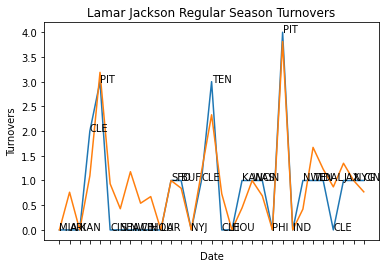

explained_variance:  0.7669
mean_squared_log_error:  0.1033
r2:  0.7494
MAE:  0.3653
MSE:  0.254
RMSE:  0.504


In [ ]:
dates = pd.to_datetime(lamar_jackson_1920[('General','Date')])
dates = dates.map(dt.datetime.toordinal)
away_binary = [0 if x == 'H' else 1 for x in lamar_jackson_1920[('General','At')]]
opp = lamar_jackson_1920[('General','Opp')]

onehot_lamar = pd.get_dummies(lamar_jackson_1920, columns=[('General','Opp')], prefix='onehot')
weeks = onehot_lamar[('General','Week')]

encodings = onehot_lamar.iloc[:,39:62]
stack = np.column_stack((dates,away_binary,weeks))

X = np.append(stack,encodings,axis=1)
X = pd.DataFrame(X)
y = pd.DataFrame(lamar_jackson_1920[('Off. Snaps','Turnovers')])
model = LinearRegression()
scores = []
kfold = KFold(n_splits=3, shuffle=True, random_state=40)


for i, (train, test) in enumerate(kfold.split(X,y)):
  model.fit(X.iloc[train,:], y.iloc[train,:])
  score = model.score(X.iloc[test,:],y.iloc[test,:])
  scores.append(score)

pred_y = model.predict(X)

pred_y = [np.zeros(1) if x < 0 else x for x in pred_y]


ax = plt.figure().gca()
x = lamar_jackson_1920[('General','Date')].values
y = lamar_jackson_1920[('Off. Snaps','Turnovers')].values
tms = lamar_jackson_1920[('General','Opp')].values.astype(str)
plt.plot(x,y)
plt.plot(x,pred_y)
plt.xlabel('Date')
plt.ylabel('Turnovers')
plt.title('Lamar Jackson Regular Season Turnovers')
i = 0
for txt in tms:
  ax.annotate(txt, (x[i], y[i]))
  i += 1
ax.set_xticklabels([])
plt.show()


regression_results(y,pred_y)

We can now use our model to predict Lamar Jackson's turnovers in the Titan's game this weekend.  

In [ ]:
ten_df = onehot_lamar[onehot_lamar['onehot_TEN'] == 1]
encodings = ten_df.iloc[0:1,39:62]
date = [pd.to_datetime("2021-01-10").toordinal()]
week = [18]
away = [1]
stack = np.column_stack((date,away,week))
X = np.append(stack,encodings,axis=1)

X = pd.DataFrame(X)

pred_y = model.predict(X)

print("Lamar Jackson's predicted number of turnovers against the Titans: " + str(pred_y[0,0]))

Lamar Jackson's predicted number of turnovers against the Titans: 1.4550334784019014


According to our model, Lamar Jackson is likely to have about 1.5 turnovers.  Much better than then the 3 turnovers suffered against the Titan's in last season's divisional playoff round.  

#2) Derrick Henry

There is simply no way around it: Derrick Henry is an absolute machine.  Henry looked like a man amongst boys last year with nearly 200 rushing yards and an impressive trick play which earned him a passing TD.  He is, the clear and obvious nfl rushing leader this season with a total of 2027 yards and 17 touchdowns per nfl.com.  Handing Derrick Henry must be a priority for the Batimore defense.  Lets take a look at Derrick Henry's game to see how this could be done.

In [ ]:
henry_plays_2020 = get_df('https://stathead.com/football/play_finder.cgi?request=1&match=all&sb=0&order_by_asc=0&order_by=yards&player_id_hint=Derrick+Henry&player_id_select=Derrick+Henry&player_id=HenrDe00&year_min=2020&year_max=2020&game_type=E&game_num_min=0&game_num_max=99&week_num_min=0&week_num_max=99&quarter%5B%5D=1&quarter%5B%5D=2&quarter%5B%5D=3&quarter%5B%5D=4&quarter%5B%5D=5&minutes_max=15&seconds_max=0&minutes_min=0&seconds_min=0&down%5B%5D=0&down%5B%5D=1&down%5B%5D=2&down%5B%5D=3&down%5B%5D=4&field_pos_min_field=team&field_pos_max_field=team&end_field_pos_min_field=team&end_field_pos_max_field=team&type%5B%5D=PASS&type%5B%5D=RUSH&type%5B%5D=PUNT&type%5B%5D=KOFF&type%5B%5D=ONSD&type%5B%5D=FG&type%5B%5D=XP&type%5B%5D=2PC&no_play=N&turnover_type%5B%5D=interception&turnover_type%5B%5D=fumble&score_type%5B%5D=touchdown&score_type%5B%5D=field_goal&score_type%5B%5D=safety&rush_direction%5B%5D=LE&rush_direction%5B%5D=LT&rush_direction%5B%5D=LG&rush_direction%5B%5D=M&rush_direction%5B%5D=RG&rush_direction%5B%5D=RT&rush_direction%5B%5D=RE&pass_location%5B%5D=SL&pass_location%5B%5D=SM&pass_location%5B%5D=SR&pass_location%5B%5D=DL&pass_location%5B%5D=DM&pass_location%5B%5D=DR',4)

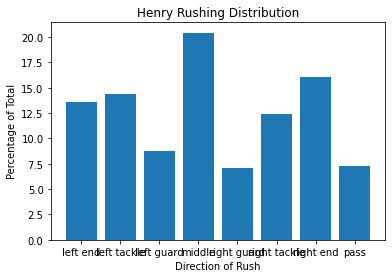

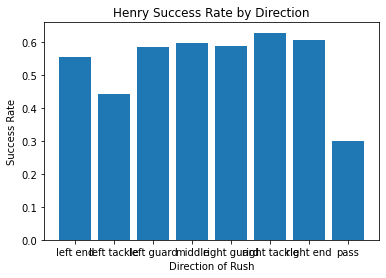

In [ ]:
import re

def find_rush_details(s):
  position = ""
  gain = 0
  if 'middle' in s:
    position = 'middle'
  elif 'left end' in s:
    position = 'left end'
  elif 'left tackle' in s:
    position = 'left tackle'
  elif 'left guard' in s:
    position = 'left guard'
  elif 'right guard' in s:
    position = 'right guard'
  elif 'right tackle' in s:
    position = 'right tackle'
  elif 'right end' in s:
    position = 'right end'
  else: 
    position = 'pass'
  yds = re.compile(r"[+-]?\d+")
  matches = yds.search(s)
  if matches is not None:
    gain = matches.group(0)
  return [position,gain]

  

henry_rushes = [find_rush_details(x) for x in henry_plays_2020['Detail']]
henry_rushes = pd.DataFrame(np.array(henry_rushes),columns=['direction','gain'])

henry_rushes = pd.concat([henry_plays_2020,henry_rushes], axis=1)
counts = henry_rushes['direction'].value_counts()


labels = ['left end', 'left tackle', 'left guard', 'middle', 'right guard', 'right tackle', 'right end','pass']

Y = [counts[3],counts[2],counts[5],counts[0],counts[7],counts[4],counts[1],counts[6]]
sums = np.sum(Y)
Y = list(map(lambda x: (x/sums) * 100,Y))
ax = plt.figure().gca()
ax.bar(labels,Y)
ax.set_ylabel('Percentage of Total')
ax.set_xlabel('Direction of Rush')
ax.set_title('Henry Rushing Distribution')

def is_success(row):
  if row['ToGo'] <= row['Yds']:
    return 1
  if row['Down'] == 1:
    if row['ToGo'] * .4 <= row['Yds']:
      return 1
  if row['Down'] == 2:
     if row['ToGo'] * .6 <= row['Yds']:
       return 1
  return 0

henry_rushes['success'] = [is_success(row) for index, row in henry_rushes.iterrows()]

def find_success_ratio(df,label):
  df = df[df['direction'] == label]
  return df['success'].sum()/len(df) 

avgs = [find_success_ratio(henry_rushes,label) for label in labels]

sums = np.sum(Y)
Y = list(map(lambda x: (x/sums) * 100,Y))
ax = plt.figure().gca()
ax.bar(labels,avgs)
ax.set_ylabel('Success Rate')
ax.set_xlabel('Direction of Rush')
t = ax.set_title('Henry Success Rate by Direction')


Here I plotted two bar graphs: one visualing the distribution of Henry's rush attempts by direction, and the other visualizing Henry's success rate by direction. (A play is condidered successful when it results in a gain of 40% of yards to go on first down, 60% of yards to go on second down, or 100% of yards to go on third/fourth down.)  You can see from the bar graphs, that Derrick Henry slightly favors the right side of the field and has greater success on average when he runs in that direction.  Don Martindale and the Raven's Defense could choose to counter this by shifting the Defensive line slightly to the right and employing the secondary to stop large runs coming from the left.  This will likely be most effective on second or third and short opportunites.  First downs may provide a different situation.

Text(0.5, 1.0, 'Henry Success Rate by Direction on First Down')

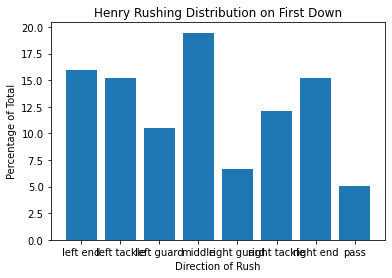

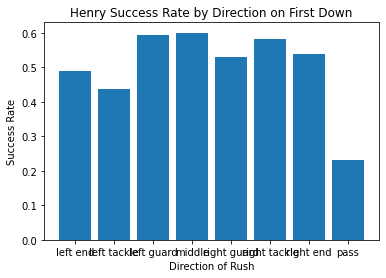

In [ ]:

henry_first_down = henry_rushes[henry_rushes['Down']==1]

counts = henry_first_down['direction'].value_counts()


labels = ['left end', 'left tackle', 'left guard', 'middle', 'right guard', 'right tackle', 'right end','pass']

Y = [counts[1],counts[3],counts[5],counts[0],counts[6],counts[4],counts[2],counts[7]]
sums = np.sum(Y)
Y = list(map(lambda x: (x/sums) * 100,Y))
ax = plt.figure().gca()
ax.bar(labels,Y)
ax.set_ylabel('Percentage of Total')
ax.set_xlabel('Direction of Rush')
ax.set_title('Henry Rushing Distribution on First Down')




avgs = [find_success_ratio(henry_first_down,label) for label in labels]
sums = np.sum(Y)
Y = list(map(lambda x: (x/sums) * 100,Y))
ax = plt.figure().gca()
ax.bar(labels,avgs)
ax.set_ylabel('Success Rate')
ax.set_xlabel('Direction of Rush')
ax.set_title('Henry Success Rate by Direction on First Down')

You can see here that specifically on first down, Henry is very unpredictable. Because of the increased distribution of runs on the left side of the field, a shift over to the right would likely be less successful.  I think on first down, the Baltimore defensive line would be best served staying central and trying to stuff runs of the middle while relying on wide line backers and corners to keep edge runs from popping off for large yardage.  This would force second and medium situations where Henry actually starts to become slightly more predictable.   

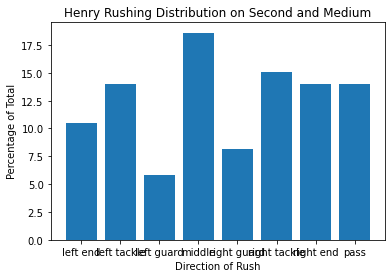

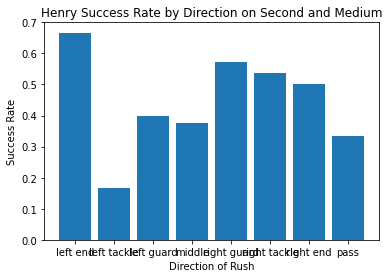

In [37]:
henry_sec_med = henry_rushes[henry_rushes['Down'] == 2]
henry_sec_med = henry_sec_med[henry_sec_med['ToGo'] >= 5]
counts = henry_sec_med['direction'].value_counts()

labels = ['left end', 'left tackle', 'left guard', 'middle', 'right guard', 'right tackle', 'right end','pass']

Y = [counts[5],counts[4],counts[7],counts[0],counts[6],counts[1],counts[3],counts[2]]
sums = np.sum(Y)
Y = list(map(lambda x: (x/sums) * 100,Y))
ax = plt.figure().gca()
ax.bar(labels,Y)
ax.set_ylabel('Percentage of Total')
ax.set_xlabel('Direction of Rush')
ax.set_title('Henry Rushing Distribution on Second and Medium')


avgs = [find_success_ratio(henry_sec_med,label) for label in labels]
sums = np.sum(Y)
Y = list(map(lambda x: (x/sums) * 100,Y))
ax = plt.figure().gca()
ax.bar(labels,avgs)
ax.set_ylabel('Success Rate')
ax.set_xlabel('Direction of Rush')
t = ax.set_title('Henry Success Rate by Direction on Second and Medium')

Although Henry tends to be successful when making runs toward the left end on second and medium/long situations he seems to favor the right side of the field somewhat strongly.  Therefore, my original suggestion to shift the defensive line to the right and rely on the secondary to stop large runs on the left may be the best option.  

Ultimately, the Raven's defense needs to understand that Derrick Henry will absolutely be gaining yardage on the ground throughout the game this Sunday.  He is simply too fast and powerful to be able to stop consistently.  The Raven's defense needs to put a focus on containing Henry rather than preventing him entirely.  This means being more disciplined and not trying to blitz and stop him behind the line on first down, but rather play it safe and choke out large runs at the cost of allowing him to gain 4 or 5 yards on first.  This should force more second and medium situations where the Titan's rush game is more predictable and they may be more likely to leave it up to the passing game, where they are less comfortable and Baltimore is better suited towards making stops.    

#3) 4th Down Conversions

The Ravens were 0/4 on fourth down conversion attempts in the January 2020 game, which was surprising after going 17/24 the whole regular season.  To be fair, the last two were in medium and long yardage situations that would not have been attempted if not trailing in the fourth quarter, but the first two were both 4th & 1 situations in the middle of the field where Baltimore failed to gain anything.  In order to predict if this will remain a problem in Sunday's game, we need to figure out: 

a) Is there likely to be 4th and short situations in the middle of the field again?
 
b) Has the Ravens offense gotten better at converting given they are put in this situation?



In order to answer the first question, let's look at the Titan's Defense in the middle of the field.

In [ ]:
titans_def_2019_fourth_midfield = get_df('https://stathead.com/football/play_finder.cgi?request=1&match=summary_all&sb=0&order_by_asc=0&order_by=yards&year_min=2019&year_max=2019&game_type=E&opp_id=oti&game_num_min=0&game_num_max=99&week_num_min=0&week_num_max=99&quarter%5B%5D=1&quarter%5B%5D=2&quarter%5B%5D=3&quarter%5B%5D=4&quarter%5B%5D=5&minutes_max=15&seconds_max=0&minutes_min=0&seconds_min=0&down%5B%5D=0&down%5B%5D=4&field_pos_min_field=team&field_pos_max_field=opp&field_pos_max=30&end_field_pos_min_field=team&end_field_pos_max_field=team&type%5B%5D=PASS&type%5B%5D=RUSH&type%5B%5D=PUNT&no_play=N&turnover_type%5B%5D=interception&turnover_type%5B%5D=fumble&score_type%5B%5D=touchdown&score_type%5B%5D=field_goal&score_type%5B%5D=safety&rush_direction%5B%5D=LE&rush_direction%5B%5D=LT&rush_direction%5B%5D=LG&rush_direction%5B%5D=M&rush_direction%5B%5D=RG&rush_direction%5B%5D=RT&rush_direction%5B%5D=RE&pass_location%5B%5D=SL&pass_location%5B%5D=SM&pass_location%5B%5D=SR&pass_location%5B%5D=DL&pass_location%5B%5D=DM&pass_location%5B%5D=DR',4)
titans_def_2020_fourth_midfield = get_df('https://stathead.com/football/play_finder.cgi?request=1&match=summary_all&sb=0&order_by_asc=0&order_by=yards&year_min=2020&year_max=2020&game_type=E&opp_id=oti&game_num_min=0&game_num_max=99&week_num_min=0&week_num_max=99&quarter%5B%5D=1&quarter%5B%5D=2&quarter%5B%5D=3&quarter%5B%5D=4&quarter%5B%5D=5&minutes_max=15&seconds_max=0&minutes_min=0&seconds_min=0&down%5B%5D=0&down%5B%5D=4&field_pos_min_field=team&field_pos_max_field=opp&field_pos_max=30&end_field_pos_min_field=team&end_field_pos_max_field=team&type%5B%5D=PASS&type%5B%5D=RUSH&type%5B%5D=PUNT&no_play=N&turnover_type%5B%5D=interception&turnover_type%5B%5D=fumble&score_type%5B%5D=touchdown&score_type%5B%5D=field_goal&score_type%5B%5D=safety&rush_direction%5B%5D=LE&rush_direction%5B%5D=LT&rush_direction%5B%5D=LG&rush_direction%5B%5D=M&rush_direction%5B%5D=RG&rush_direction%5B%5D=RT&rush_direction%5B%5D=RE&pass_location%5B%5D=SL&pass_location%5B%5D=SM&pass_location%5B%5D=SR&pass_location%5B%5D=DL&pass_location%5B%5D=DM&pass_location%5B%5D=DR',4)

titans_def_midfield_fourth = pd.concat([titans_def_2019_fourth_midfield,titans_def_2020_fourth_midfield])



titans_def_midfield_fourth = titans_def_midfield_fourth[titans_def_midfield_fourth['Date'].notnull()]

clean_location = lambda df: [100-int(loc.split()[1]) if loc.split()[0] == 'OTI' else int(loc.split()[1]) for loc in df['Location']]

titans_def_midfield_fourth['Location'] = clean_location(titans_def_midfield_fourth)     
display(titans_def_midfield_fourth)

,Date,Tm,Opp,Quarter,Time,Down,ToGo,Location,Score,Detail,Yds,EPB,EPA,Diff
0,2019-11-10,Chiefs,Titans,3,3:25,4,2,57,19-20,Patrick Mahomes pass complete short left to Da...,10,0.40,3.38,2.98
1,2019-09-29,Falcons,Titans,4,12:26,4,4,18,10-24,Matt Ryan pass complete short left to Mohamed ...,8,-2.24,0.67,2.91
2,2019-12-29,Texans,Titans,3,6:35,4,2,58,7-21,A.J. McCarron pass complete short left to Duke...,3,0.46,2.98,2.52
3,2019-10-27,Buccaneers,Titans,2,11:34,4,1,59,3-14,Jameis Winston up the middle for 2 yards (tack...,2,0.53,2.98,2.45
4,2019-10-06,Bills,Titans,1,4:55,4,1,59,0-0,Josh Allen up the middle for 2 yards (tackle b...,2,0.53,2.98,2.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55,2020-09-14,Broncos,Titans,1,9:04,4,8,37,0-0,"Sam Martin punts 51 yards, returned by Kalif R...",0,-0.91,0.32,1.23
56,2020-11-12,Colts,Titans,4,3:09,4,2,40,34-17,"Rigoberto Sanchez punts 46 yards, returned by ...",0,-0.72,0.14,0.86
57,2020-09-20,Jaguars,Titans,2,7:43,4,21,40,7-14,"Logan Cooke punts 45 yards, returned by Kalif ...",0,-0.72,0.22,0.94
58,2020-12-06,Browns,Titans,4,5:50,4,10,44,41-21,"Jamie Gillan punts 47 yards, fair catch by Kal...",0,-0.46,0.38,0.84


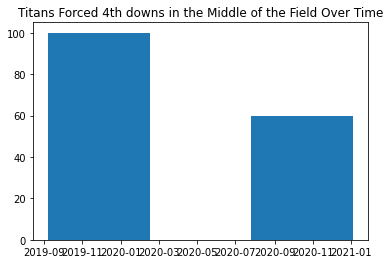

In [38]:
titans_def_midfield_fourth = titans_def_midfield_fourth.sort_values(by=['Date'])
dates = titans_def_midfield_fourth['Date']

dates_list = [dt.datetime.strptime(date,"%Y-%m-%d").date() for date in dates]

n = plt.hist(dates_list,bins=3)
t = plt.title('Titans Forced 4th downs in the Middle of the Field Over Time')

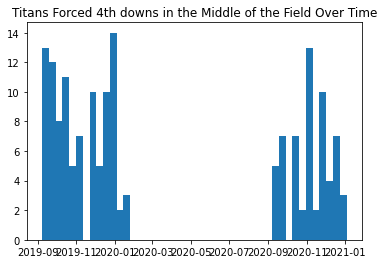

In [ ]:
ax2 = plt.hist(dates_list,bins=45)
t = plt.title("Titans Forced 4th downs in the Middle of the Field Over Time")

These histograms represent the number of fourth down situations forced by the Titan's defense outside of field goal range over the last two seasons.  On both plots the empty space in the middle represents the off season so you can see the difference between the 2019 and 2020 seasons.  Clearly, the Titan's defense was much more proficient at stopping teams on third down in 2019 than they have been in the 2020 season.  The Raven's offense should be able to capitalize on this, preventing fourth down situations in the first place.  

In [ ]:
ravens_2019 = get_df('https://stathead.com/football/play_finder.cgi?request=1&match=summary_all&sb=0&order_by_asc=1&order_by=game_date&year_min=2019&year_max=2019&game_type=E&team_id=rav&game_num_min=0&game_num_max=99&week_num_min=0&week_num_max=99&quarter%5B%5D=1&quarter%5B%5D=2&quarter%5B%5D=3&quarter%5B%5D=4&quarter%5B%5D=5&minutes_max=15&seconds_max=0&minutes_min=0&seconds_min=0&down%5B%5D=0&down%5B%5D=3&down%5B%5D=4&yds_to_go_min=1&yds_to_go_max=3&field_pos_min_field=team&field_pos_max_field=opp&field_pos_max=30&end_field_pos_min_field=team&end_field_pos_max_field=team&type%5B%5D=PASS&type%5B%5D=RUSH&no_play=N&turnover_type%5B%5D=interception&turnover_type%5B%5D=fumble&score_type%5B%5D=touchdown&score_type%5B%5D=field_goal&score_type%5B%5D=safety&rush_direction%5B%5D=LE&rush_direction%5B%5D=LT&rush_direction%5B%5D=LG&rush_direction%5B%5D=M&rush_direction%5B%5D=RG&rush_direction%5B%5D=RT&rush_direction%5B%5D=RE&pass_location%5B%5D=SL&pass_location%5B%5D=SM&pass_location%5B%5D=SR&pass_location%5B%5D=DL&pass_location%5B%5D=DM&pass_location%5B%5D=DR',4)
ravens_2020 = get_df('https://stathead.com/football/play_finder.cgi?request=1&match=summary_all&sb=0&order_by_asc=1&order_by=game_date&year_min=2020&year_max=2020&game_type=E&team_id=rav&game_num_min=0&game_num_max=99&week_num_min=0&week_num_max=99&quarter%5B%5D=1&quarter%5B%5D=2&quarter%5B%5D=3&quarter%5B%5D=4&quarter%5B%5D=5&minutes_max=15&seconds_max=0&minutes_min=0&seconds_min=0&down%5B%5D=0&down%5B%5D=3&down%5B%5D=4&yds_to_go_min=1&yds_to_go_max=3&field_pos_min_field=team&field_pos_max_field=opp&field_pos_max=30&end_field_pos_min_field=team&end_field_pos_max_field=team&type%5B%5D=PASS&type%5B%5D=RUSH&no_play=N&turnover_type%5B%5D=interception&turnover_type%5B%5D=fumble&score_type%5B%5D=touchdown&score_type%5B%5D=field_goal&score_type%5B%5D=safety&rush_direction%5B%5D=LE&rush_direction%5B%5D=LT&rush_direction%5B%5D=LG&rush_direction%5B%5D=M&rush_direction%5B%5D=RG&rush_direction%5B%5D=RT&rush_direction%5B%5D=RE&pass_location%5B%5D=SL&pass_location%5B%5D=SM&pass_location%5B%5D=SR&pass_location%5B%5D=DL&pass_location%5B%5D=DM&pass_location%5B%5D=DR',4)
ravens_2019 = ravens_2019.sort_values(by='Date')
ravens_2020 = ravens_2020.sort_values(by='Date')

first_down = lambda df: [1 if row['Yds'] >= row['ToGo'] else 0 for index, row in df.iterrows()]
ravens_2019['First'] =  first_down(ravens_2019)
ravens_2020['First'] =  first_down(ravens_2020)

display(ravens_2019.head(5))
display(ravens_2020.head(5))

ravens_third_2019 = ravens_2019[ravens_2019['Down'] == 3]
ravens_fourth_2019 = ravens_2019[ravens_2019['Down'] == 4]
ravens_third_2020 = ravens_2020[ravens_2020['Down'] == 3]
ravens_fourth_2020 = ravens_2020[ravens_2020['Down'] == 4]

print("\n")
print("Ravens 3rd and short Conversion Percentage 2019: " + str(np.sum(ravens_third_2019['First'])/len(ravens_third_2019)))
print("Ravens 3rd and short Conversion Percentage 2020: " + str(np.sum(ravens_third_2020['First'])/len(ravens_third_2020)))
print("\n")
print("Ravens 4th and short Conversion Percentage 2019: " + str(np.sum(ravens_fourth_2019['First'])/len(ravens_fourth_2019)))
print("Ravens 4th and short Conversion Percentage 2020: " + str(np.sum(ravens_fourth_2020['First'])/len(ravens_fourth_2020)))



,Date,Tm,Opp,Quarter,Time,Down,ToGo,Location,Score,Detail,Yds,EPB,EPA,Diff,First
0,2019-09-08,Ravens,Dolphins,1,4:28,3,3,RAV 17,20-0,Lamar Jackson pass complete deep middle to Mar...,83,-0.60,7.00,7.60,1
1,2019-09-08,Ravens,Dolphins,2,9:18,3,1,RAV 34,28-3,Gus Edwards right guard for no gain (tackle by...,0,0.56,-1.11,-1.67,0
2,2019-09-08,Ravens,Dolphins,4,6:32,3,1,RAV 30,59-10,Gus Edwards left guard for 2 yards (tackle by ...,2,0.30,1.07,0.77,1
3,2019-09-15,Ravens,Cardinals,1,5:17,3,2,CRD 42,7-0,Lamar Jackson left guard for -1 yards (tackle ...,-1,2.08,0.40,-1.68,0
4,2019-09-15,Ravens,Cardinals,1,4:39,4,3,CRD 43,7-0,Lamar Jackson pass incomplete deep right inten...,0,0.40,-1.80,-2.20,0


,Date,Tm,Opp,Quarter,Time,Down,ToGo,Location,Score,Detail,Yds,EPB,EPA,Diff,First
0,2020-09-20,Ravens,Texans,3,12:17,3,1,RAV 35,20-10,Gus Edwards left guard for 14 yards (tackle by...,14,0.63,2.19,1.56,1
1,2020-09-20,Ravens,Texans,4,12:04,4,1,HTX 30,29-13,"Mark Ingram left end for 30 yards, touchdown",30,1.52,7.00,5.48,1
2,2020-09-20,Ravens,Texans,4,6:32,4,1,RAV 36,30-16,Lamar Jackson up the middle for 2 yards (tackl...,2,-0.98,1.47,2.45,1
3,2020-09-20,Ravens,Texans,4,5:31,3,2,RAV 46,30-16,Gus Edwards left tackle for 15 yards (tackle b...,15,1.29,2.98,1.69,1
4,2020-09-28,Ravens,Chiefs,1,13:33,3,2,RAV 33,0-0,Lamar Jackson right end for 30 yards (tackle b...,30,0.43,3.12,2.69,1




Ravens 3rd and short Conversion Percentage 2019: 0.75
Ravens 3rd and short Conversion Percentage 2020: 0.7837837837837838


Ravens 4th and short Conversion Percentage 2019: 0.5833333333333334
Ravens 4th and short Conversion Percentage 2020: 0.9090909090909091


The Ravens offense has not only improved in 3rd and short situations, preventing 4th down from becoming a problem, but they have also improved in 4th and short situations.  Given the Titans defense's reduction in third down stops outside of field goal range and the improvement in 3rd and 4th down situations from the Raven's offense, turnovers on downs should prove to be much less of a problem this Sunday than it was in the same matchup a year ago.  

#Conclusion

As I said at the beginning of this project, Baltimore's revenge efforts this Sunday will likely rely on fixing these key mistakes.  Based on my analysis of the two teams I can say that:

1. Interceptions and Fumbles from Lamar Jackson will likely still be a problem, but not to the degree they were last year.

2. Derrick Henry is still a major issue, but (contrary to popular belief) he is containable.  If Baltimore can stop him from gaining major yardage on first downs he becomes much more manageable, and they can force the Titans into passing situation where they are less comfortable.  

3. There will likely be fewer fourth down situations for Baltimore due to the Titans inability to make stops outside of field goal range.  Furthermore, the Ravens are more likely to be able to convert on this situations if they do arise, preventing Tennessee from receiving the ball in a great field position.    

This game will almost definitely be hard fought, but the advantage has to go the Ravens, at the very least to put on a better performance than they did last year.  Anything can happen in playoff football, but I wouldn't bet against Baltimore this Sunday.  The Ravens are a dangerous team, but they are going to have to remain disciplined and focused if they want to avenge their embarrasing defeat last season.     